## Table Of Contents
<font size=3rem>
    
0 -**[ GPU SETTINGS](#GPU-SETTINGS)**<br>
1 -**[ BUSINESS UNDERSTANDING](#BUSINESS-UNDERSTANDING)**<br>
2 -**[ DATA UNDERSTANDING](#DATA-UNDERSTANDING)**<br>
3 -**[ DATA PREPARATION](#DATA-PREPARATION)**<br>
4 -**[ MODELING](#MODELING)**<br>
5 -**[ EVALUATION](#EVALUATION)<br>**
</font>
___

# BUSINESS UNDERSTANDING

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

- Pneumonia Chest Xray Image Classification
    - Objective
        - To attain the highest level of accuracy and repeatability to detect cases of pneumonia while minimizing false positives/negatives.
    - Priority
         - (1) Do not want to tell a sick person they are healthy
            
         - (2) Accurately identify pneumonia
         - (3) Avoid telling healthy person they are sick

## Import Tools

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
import cv2
import random
import datetime
from tensorflow.python.client import device_lib
from tensorflow.keras.applications.densenet import DenseNet201

Using TensorFlow backend.


In [2]:
notebook_original_start = datetime.datetime.now()

# GPU SETTINGS

In [3]:
# https://github.com/jeffheaton/present/blob/master/youtube/gpu/keras-dual-gpu.ipynb
# https://www.youtube.com/watch?v=HCLmM1PyDIs

# List of Local Devices
devices = device_lib.list_local_devices()

# Calculate size of device
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

# Data in Devices, Type, Name, Abrv, Memory
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 2070 SUPER || GPU || 5.8 GiB


In [4]:
print("Number of GPU's Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU's Available:  1


## FUNCTIONS

In [5]:
def get_num_pixels(pixel_path):
    '''
    Gets width and height of image
    :param pixel_path: String
    :return width, height: Tuple of Int
    '''
    
    width, height = Image.open(pixel_path).size
    return width, height

In [6]:
def get_image_pixels_and_paths(path):
    '''
    Joins the classes of called picture pixel count for total of called class
    :param path: String
    :return None: prints out pixel dimensions
    '''
    
    # Iterate through 5 entries to print number of pixels from image
    for path, subdirs, files in os.walk(path):
        for index, name in enumerate(files):
            image_path = os.path.join(path,name)
            print(get_num_pixels(image_path))
            if index >= 4:
                break

In [7]:
# Code Sourced from Learn.Co, modified for this project
# https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
def visualize_training_results(results):
    '''
    Renders out metric results into graphs
    :param results: tensorflow.python.keras.callbacks.History
    :return None: print out graphs
    '''
    # Assign variable for model history results
    history = results.history
    
    # Loss metric
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Accuracy metric
    plt.figure()
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['accuracy','val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Precision metric
    plt.figure()
    plt.plot(history['precision'])
    plt.plot(history['val_precision'])
    plt.legend(['precision','val_precision'])
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()
    
    # Recall metric
    plt.figure()
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    plt.legend(['recall','val_recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

# DATA UNDERSTANDING

In [55]:
#Home Directory
home_path = r'C:\Users\c_fre\Learn.co\Module_4_Project\Image-Classification\chest_xray'

#Train Directory
train_path = os.path.join(home_path,'train')

#Validation Directory
val_path = os.path.join(home_path,'val')

#Test Directory
test_path = os.path.join(home_path,'test')

#Train Subdirectories
normal_train_path = os.path.join(train_path,'NORMAL')

pneumonia_train_path = os.path.join(train_path,'PNEUMONIA')

#Validation Subdirectories
normal_val_path = os.path.join(val_path,'NORMAL')

pneumonia_val_path = os.path.join(val_path,'PNEUMONIA')

#Test Subdirectories

normal_test_path = os.path.join(test_path,'NORMAL')

pneumonia_test_path = os.path.join(test_path,'PNEUMONIA')

In [57]:
#Unfiltered Home Directory
unfiltered_home_path = r'C:\Users\c_fre\Learn.co\Module_4_Project\Image-Classification\chest_xray_original'

#Unfiltered Train Directory
unfiltered_train_path = os.path.join(unfiltered_home_path,'train')

#Unfiltered Validation Directory
unfiltered_val_path = os.path.join(unfiltered_home_path,'val')

#Unfiltered Test Directory
unfiltered_test_path = os.path.join(unfiltered_home_path,'test')

#Unfiltered Train Subdirectories
unfiltered_normal_train_path = os.path.join(unfiltered_train_path,'NORMAL')

unfiltered_pneumonia_train_path = os.path.join(unfiltered_train_path,'PNEUMONIA')

#Unfiltered Validation Subdirectories
unfiltered_normal_val_path = os.path.join(unfiltered_val_path,'NORMAL')

unfiltered_pneumonia_val_path = os.path.join(unfiltered_val_path,'PNEUMONIA')

#Unfiltered Test Subdirectories

unfiltered_normal_test_path = os.path.join(unfiltered_test_path,'NORMAL')

unfiltered_pneumonia_test_path = os.path.join(unfiltered_test_path,'PNEUMONIA')

In [9]:
#Print to Verify Directory Pathways
print('Directory Contents:',os.listdir(home_path))
print('train Contents:',os.listdir(train_path))
print('val Contents:',os.listdir(val_path))
print('test Contents:',os.listdir(test_path))

Directory Contents: ['test', 'train', 'val']
train Contents: ['NORMAL', 'PNEUMONIA']
val Contents: ['NORMAL', 'PNEUMONIA']
test Contents: ['NORMAL', 'PNEUMONIA']


In [10]:
#Cases in Training Sets
print("Number of cases in Training:",len(os.listdir(normal_train_path)) +len(os.listdir(pneumonia_train_path)))

#Pneumonia Cases in Training
print("Number of Pneumonia cases in Training:",len(os.listdir(pneumonia_train_path)))

#Normal Cases in Training
print("Number of Normal cases in Training:",len(os.listdir(normal_train_path)))

Number of cases in Training: 2218
Number of Pneumonia cases in Training: 1109
Number of Normal cases in Training: 1109


In [11]:
# Cases in Validation Sets
print("Number of cases in Validation:",len(os.listdir(normal_val_path)) +len(os.listdir(pneumonia_val_path)))

# Pneumonia Cases in Validation
print("Number of Pneumonia cases in Validation:",len(os.listdir(pneumonia_val_path)))

# Normal Cases in Validation
print("Number of Normal cases in Validation:",len(os.listdir(normal_val_path)))

Number of cases in Validation: 474
Number of Pneumonia cases in Validation: 237
Number of Normal cases in Validation: 237


In [12]:
#Cases in Test Sets
print("Number of cases in Test:",len(os.listdir(normal_test_path)) +len(os.listdir(pneumonia_test_path)))

#Pneumonia Cases in Test
print("Number of Pneumonia cases in Test:",len(os.listdir(pneumonia_test_path)))

#Normal cases in Test
print("Number of Normal cases in Test:",len(os.listdir(normal_test_path)))

Number of cases in Test: 474
Number of Pneumonia cases in Test: 237
Number of Normal cases in Test: 237


In [13]:
# #Total number of Normal Cases
print("Total number of Normal cases:",
      len(os.listdir(normal_test_path))+
      len(os.listdir(normal_train_path))+
      len(os.listdir(normal_val_path)))

#Total number of Pneumonia Cases
print("Total number of Pneumonia cases:",
      len(os.listdir(pneumonia_test_path))+
      len(os.listdir(pneumonia_train_path))+
      len(os.listdir(pneumonia_val_path)))

Total number of Normal cases: 1583
Total number of Pneumonia cases: 1583


In [14]:
# Validation Pixel Size
get_image_pixels_and_paths(val_path)

(1214, 662)
(1570, 1164)
(1550, 1033)
(1638, 1323)
(1782, 1434)
(2048, 1656)
(944, 536)
(920, 568)
(848, 632)
(856, 536)


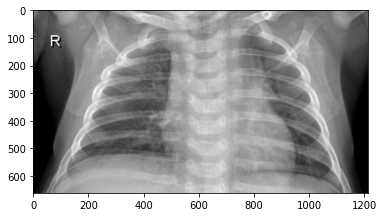

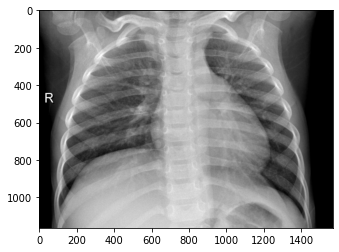

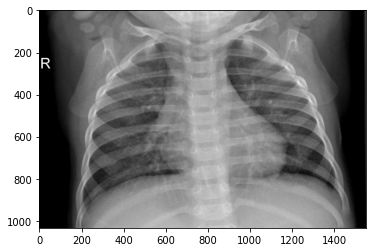

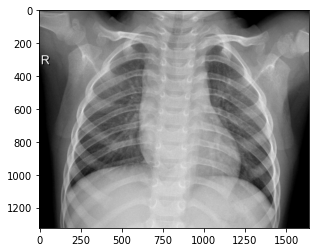

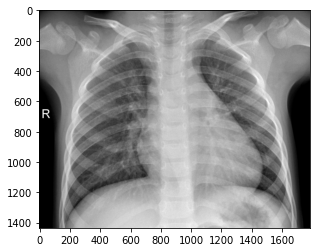

In [15]:
# Display all images in Normal Validatoin pathway
normal_val_images_display = os.listdir(normal_val_path)[:5]
for image_name in normal_val_images_display:
    image_path = os.path.join(normal_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

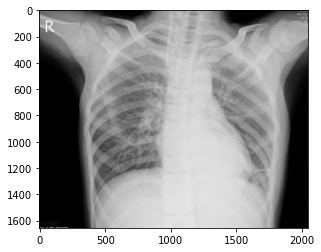

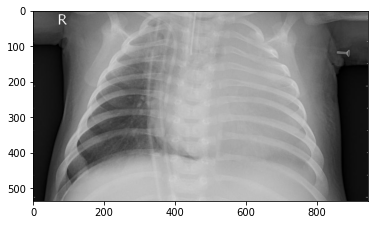

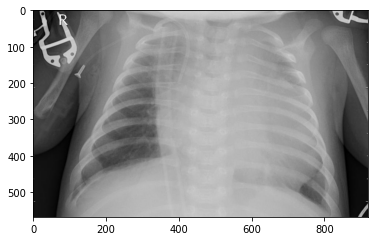

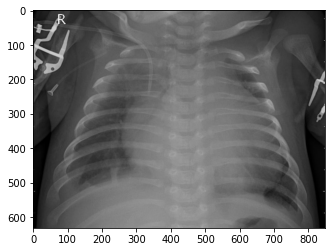

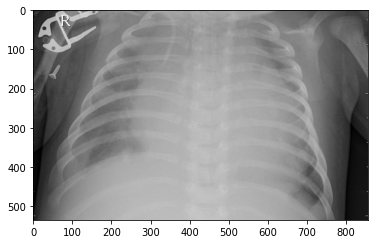

In [16]:
# Display all images in Pneumonia validation pathway
pneumonia_val_image_display = os.listdir(pneumonia_val_path)[:5]
for image_name in pneumonia_val_image_display:
    image_path = os.path.join(pneumonia_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

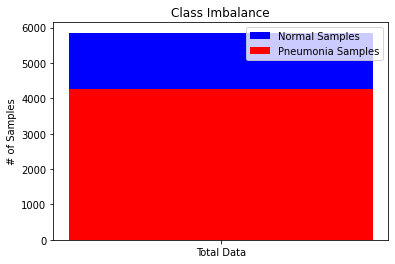

<Figure size 216x936 with 0 Axes>

In [53]:
status = ['Total Data']

normal_samples = len(os.listdir(unfiltered_normal_train_path)) + len(os.listdir(unfiltered_normal_val_path)) + len(os.listdir(unfiltered_normal_test_path))        

pneumonia_samples = len(os.listdir(unfiltered_pneumonia_train_path)) + len(os.listdir(unfiltered_pneumonia_val_path)) + len(os.listdir(unfiltered_pneumonia_test_path))
    
ind = [x for x, _ in enumerate(status)]

plt.bar(ind, normal_samples, width=0.8, label='Normal Samples', color='blue',bottom=pneumonia_samples)
plt.bar(ind, pneumonia_samples, width=0.8, label='Pneumonia Samples', color='red')

plt.xticks(ind,status)
plt.ylabel('# of Samples')
plt.legend(loc='upper right')
plt.title('Class Imbalance on Original Data')

f = plt.figure()
f.set_figwidth(4)
f.set_figheight(1)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

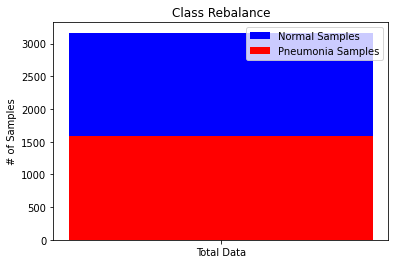

<Figure size 288x72 with 0 Axes>

In [56]:
status = ['Total Data']

normal_samples = len(os.listdir(normal_train_path)) + len(os.listdir(normal_val_path)) + len(os.listdir(normal_test_path))        

pneumonia_samples = len(os.listdir(pneumonia_train_path)) + len(os.listdir(pneumonia_val_path)) + len(os.listdir(pneumonia_test_path))
    
ind = [x for x, _ in enumerate(status)]

plt.bar(ind, normal_samples, width=0.8, label='Normal Samples', color='blue',bottom=pneumonia_samples)
plt.bar(ind, pneumonia_samples, width=0.8, label='Pneumonia Samples', color='red')

plt.xticks(ind,status)
plt.ylabel('# of Samples')
plt.legend(loc='upper right')
plt.title('Class Rebalance')

f = plt.figure()
f.set_figwidth(4)
f.set_figheight(1)

plt.show

# DATA PREPARATION

In [17]:
# Double default batch size due to computer hardware
batch_size = 64

# Set all image sizes universally
img_width, img_height = 200,200

In [18]:
# Augmentation of Training data, rescale
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")


# Rescale validation data
val_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Rescale test data
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [19]:
# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

# Validation Generator
valid_generator = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

Found 2218 images belonging to 2 classes.
Found 474 images belonging to 2 classes.
Found 474 images belonging to 2 classes.


# MODELING

## Multi Layer Perceptron

In [20]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [21]:
# Sequential: as we want to build layers upon each other
mlp_model = keras.Sequential()

In [22]:
# Fuse paths without losing scalability
mlp_model.add(keras.layers.Flatten())

In [23]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [24]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [25]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [26]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
mlp_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [27]:
# Full input, Binary output with sigmoid
mlp_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [28]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
mlp_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [29]:
# Fit Model, 10 Epochs
mlp_history = mlp_model.fit(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                            validation_steps = valid_generator.n//valid_generator.batch_size,
                            epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
34/34 [==============================] - 37s 1s/step - loss: 1.4500 - accuracy: 0.5543 - precision: 0.5584 - recall: 0.5315 - val_loss: 0.6828 - val_accuracy: 0.5670 - val_precision: 1.0000 - val_recall: 0.1491
Epoch 2/10
34/34 [==============================] - 33s 963ms/step - loss: 0.5247 - accuracy: 0.7284 - precision: 0.7406 - recall: 0.7085 - val_loss: 0.5325 - val_accuracy: 0.7254 - val_precision: 0.9720 - val_recall: 0.4643
Epoch 3/10
34/34 [==============================] - 33s 972ms/step - loss: 0.4086 - accuracy: 0.8176 - precision: 0.8320 - recall: 0.7928 - val_loss: 0.3332 - val_accuracy: 0.8661 - val_precision: 0.8694 - val_recall: 0.8616
Epoch 4/10
34/34 [==============================] - 33s 965ms/step - loss: 0.3624 - accuracy: 0.8384 - precision: 0.8506 - recall: 0.8222 - val_loss: 0.3502 - val_accuracy: 0.8393 - val_precision: 0.9578 - val_recall: 0.7098
Epoch 5/10
34/34 [==============================] - 33s 964ms/step - loss: 0.3483 - accuracy: 0.8435 - 

In [30]:
# Save Model Locally
mlp_model.save("MLP_Initial_Model")

INFO:tensorflow:Assets written to: MLP_Initial_Model\assets


In [31]:
# Summary of Model
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                7680064   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 7,682,817
Trainable params: 7,682,817
Non-trainable params: 0
______________________________________________

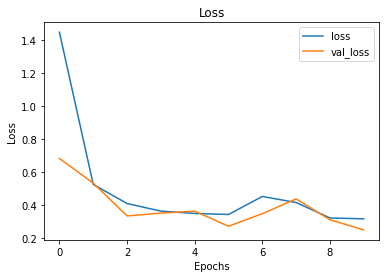

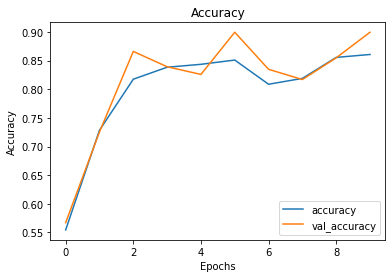

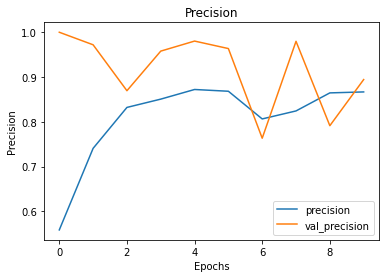

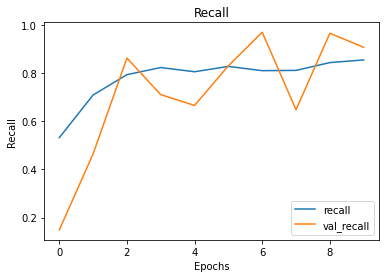

In [33]:
# Visualize Model Metrics
visualize_training_results(mlp_history)

In [34]:
# Evaluate against Training set
mlp_results_train = mlp_model.evaluate(train_generator)

35/35 [==============================] - 30s 851ms/step - loss: 0.3013 - accuracy: 0.8742 - precision: 0.8379 - recall: 0.9279


In [35]:
# Evaluate against Test set
mlp_results_test = mlp_model.evaluate(test_generator)

8/8 [==============================] - 4s 436ms/step - loss: 0.2640 - accuracy: 0.8840 - precision: 0.8730 - recall: 0.8987


## CNN Model

In [37]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [38]:
# Sequential: as we want to build layers upon each other
cnn_model = keras.Sequential()

In [39]:
# 2D Convolution Layer over Images, Generate 64 filters and multiply across the image
# Filter Images to highlight features
cnn_model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3),
                                  activation='relu',
                                  input_shape=(img_width, img_height, 3)))

In [40]:
# Group images into 2x2, votes on largest, features maintained
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

In [41]:
# Fuse paths without losing scalability
cnn_model.add(keras.layers.Flatten())

In [42]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [43]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [44]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [45]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [46]:
# Full input, Binary output with sigmoid
cnn_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [47]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
cnn_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [48]:
# Summary of Model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 627264)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                40144960  
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [49]:
# Fit Model, 10 Epochs
cnn_history = cnn_model.fit(train_generator,
                        validation_data = valid_generator,
                        steps_per_epoch = train_generator.n//train_generator.batch_size,
                        validation_steps = valid_generator.n//valid_generator.batch_size,
                        epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
34/34 [==============================] - 35s 959ms/step - loss: 0.7674 - accuracy: 0.5715 - precision: 0.5649 - recall: 0.6262 - val_loss: 0.6210 - val_accuracy: 0.6830 - val_precision: 0.6143 - val_recall: 0.9911
Epoch 2/10
34/34 [==============================] - 33s 973ms/step - loss: 0.5623 - accuracy: 0.6945 - precision: 0.7051 - recall: 0.6657 - val_loss: 0.3544 - val_accuracy: 0.8638 - val_precision: 0.9459 - val_recall: 0.7743
Epoch 3/10
34/34 [==============================] - 33s 967ms/step - loss: 0.3388 - accuracy: 0.8524 - precision: 0.8661 - recall: 0.8322 - val_loss: 0.3880 - val_accuracy: 0.8304 - val_precision: 0.9868 - val_recall: 0.6696
Epoch 4/10
34/34 [==============================] - 33s 968ms/step - loss: 0.2992 - accuracy: 0.8733 - precision: 0.8810 - recall: 0.8621 - val_loss: 0.2218 - val_accuracy: 0.9286 - val_precision: 0.9537 - val_recall: 0.9035
Epoch 5/10
34/34 [==============================] - 33s 966ms/step - loss: 0.2583 - accuracy: 0.8923

In [50]:
# Save model locally
cnn_model.save("CNN_Initial_Model")

INFO:tensorflow:Assets written to: CNN_Initial_Model\assets


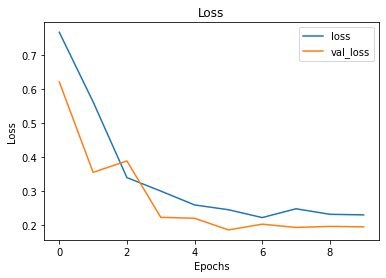

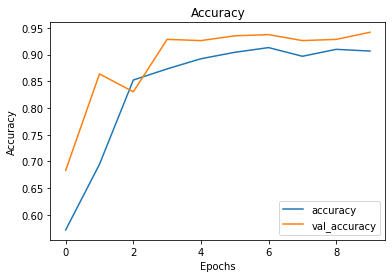

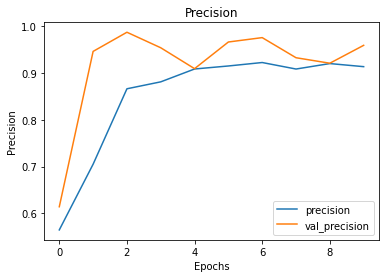

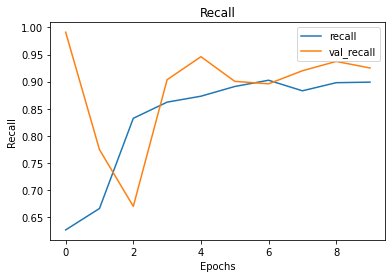

In [52]:
# Visualize Model Metrics
visualize_training_results(cnn_history)

In [53]:
# Evaluate against Training set
cnn_results_train = cnn_model.evaluate(train_generator)
cnn_results_train

35/35 [==============================] - 30s 850ms/step - loss: 0.2078 - accuracy: 0.9216 - precision: 0.9141 - recall: 0.9306


[0.2078268975019455,
 0.9215509295463562,
 0.9140832424163818,
 0.9305680990219116]

In [54]:
# Evaluate against Test set
cnn_results_test = cnn_model.evaluate(test_generator)
cnn_results_test

8/8 [==============================] - 4s 429ms/step - loss: 0.1715 - accuracy: 0.9409 - precision: 0.9336 - recall: 0.9494


[0.1714867502450943, 0.9409282803535461, 0.9336099624633789, 0.949367105960846]

## Finetune Models

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

### MLP Finetune

In [55]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [56]:
# Checkpoint, Monitor Loss, Save best results
mlp_checkpoint = tf.keras.callbacks.ModelCheckpoint("MLP_Finetune_Checkpoint",
                                                monitor="val_loss",
                                                save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
mlp_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  restore_best_weights=True)

In [57]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
mlp_finetune_history = mlp_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[mlp_checkpoint, mlp_early_stopping]
)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
34/34 [==============================] - 33s 985ms/step - loss: 0.2987 - accuracy: 0.8705 - precision: 0.8718 - recall: 0.8678 - val_loss: 0.2768 - val_accuracy: 0.8906 - val_precision: 0.9684 - val_recall: 0.8106
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 2/100
34/34 [==============================] - 33s 965ms/step - loss: 0.3102 - accuracy: 0.8709 - precision: 0.8789 - recall: 0.8610 - val_loss: 0.2264 - val_accuracy: 0.9152 - val_precision: 0.9227 - val_recall: 0.9062
Epoch 3/100
34/34 [==============================] - 33s 982ms/step - loss: 0.3872 - accuracy: 0.8347 - precision: 0.8452 - recall: 0.8184 - val_loss: 0.4527 - val_accuracy: 0.8080 - val_precision: 0.9863 - val_recall: 0.6316
Epoch 4/100
34/34 [==============================] - 33s 978ms/step - loss: 0.3416 - accuracy: 0.8528 - precision: 0.8554 - recall: 0.8482 - val_loss: 0.3159 - val_accuracy: 0.8705 - val_precision: 0.9722 - val_recall: 0.7675
Epoch 5/100
34/34 [===========

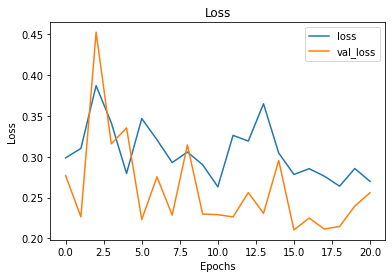

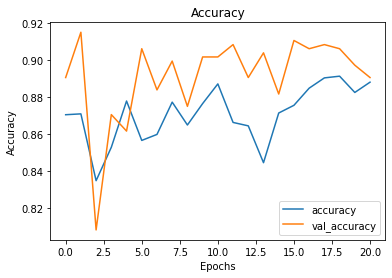

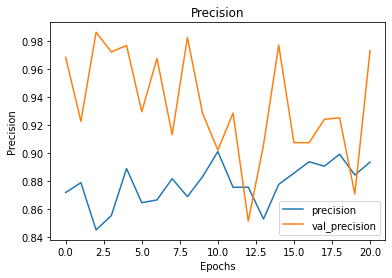

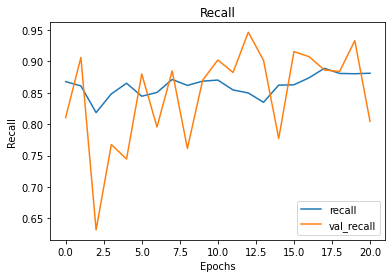

In [59]:
# Visualize Model Metrics
visualize_training_results(mlp_finetune_history)

In [60]:
# Evaluate model against Training set
mlp_results_train = mlp_model.evaluate(train_generator)

35/35 [==============================] - 30s 865ms/step - loss: 0.2682 - accuracy: 0.8891 - precision: 0.8698 - recall: 0.9152


In [61]:
# Evaluate model again Test set
mlp_results_test = mlp_model.evaluate(test_generator)

8/8 [==============================] - 4s 459ms/step - loss: 0.2546 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987


### CNN Finetune

In [62]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [63]:
# Checkpoint, Monitor Loss, Save best results
cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint("CNN_Finetune_Checkpoint",
                                                monitor="loss",
                                                save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="loss",
                                                  restore_best_weights=True)

In [64]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
cnn_finetune_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[cnn_checkpoint, cnn_early_stopping]
)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
34/34 [==============================] - 34s 1s/step - loss: 0.2125 - accuracy: 0.9164 - precision: 0.9278 - recall: 0.9038 - val_loss: 0.1860 - val_accuracy: 0.9442 - val_precision: 0.9670 - val_recall: 0.9193
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 2/100
34/34 [==============================] - 35s 1s/step - loss: 0.2010 - accuracy: 0.9197 - precision: 0.9193 - recall: 0.9201 - val_loss: 0.1886 - val_accuracy: 0.9353 - val_precision: 0.9181 - val_recall: 0.9552
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 3/100
34/34 [==============================] - 37s 1s/step - loss: 0.2335 - accuracy: 0.9058 - precision: 0.9082 - recall: 0.9023 - val_loss: 0.1983 - val_accuracy: 0.9375 - val_precision: 0.9457 - val_recall: 0.9289
Epoch 4/100
34/34 [==============================] - 35s 1s/step - loss: 0.2213 - accuracy: 0.9146 - precision: 0.9252 - recall: 0.9010 - val_loss: 0.2567 - val_accuracy: 0.9129 - val_precision: 0.87

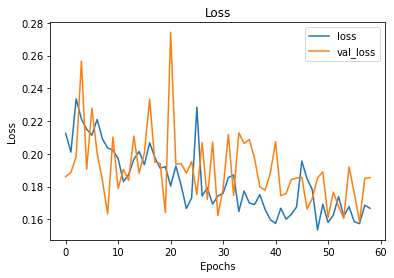

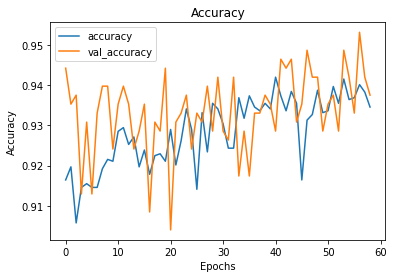

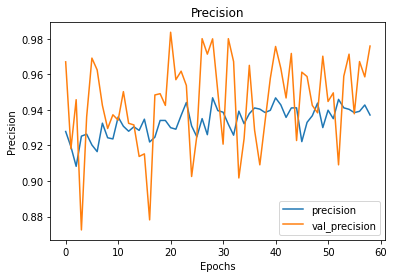

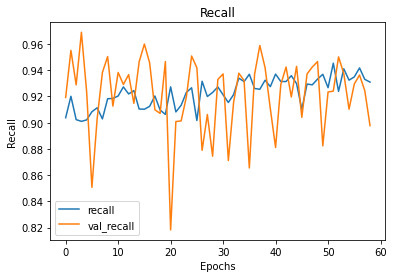

In [66]:
# Visualize Model Metrics
visualize_training_results(cnn_finetune_history)

In [67]:
# Evaluate against Training set
cnn_results_train = cnn_model.evaluate(train_generator)

35/35 [==============================] - 30s 866ms/step - loss: 0.1683 - accuracy: 0.9342 - precision: 0.9147 - recall: 0.9576


In [68]:
# Evaluate against Test set
cnn_results_test = cnn_model.evaluate(test_generator)

8/8 [==============================] - 4s 465ms/step - loss: 0.1209 - accuracy: 0.9620 - precision: 0.9660 - recall: 0.9578


## Pretrained Model

In [69]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [70]:
# Initialize Pretrain Base Model
pretrain_base = DenseNet201(weights=None,
                 include_top=False,
                 input_shape=(200, 200, 3))

# Define Model Architecture
pretrain_model = keras.Sequential()
pretrain_model.add(pretrain_base)
pretrain_model.add(keras.layers.Flatten())
pretrain_model.add(keras.layers.Dense(64, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(256, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Do NOT train the base
pretrain_base.trainable = False

# Summary of Model
pretrain_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 69120)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4423744   
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [71]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
pretrain_model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')])

In [72]:
# Fit Model, 10 Epochs
pretrain_model_history = pretrain_model.fit(train_generator,
                                            validation_data = valid_generator,
                                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                                            validation_steps = valid_generator.n//valid_generator.batch_size,
                                            epochs=10)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
34/34 [==============================] - 46s 1s/step - loss: 0.6941 - accuracy: 0.5311 - precision: 0.5341 - recall: 0.4805 - val_loss: 0.6869 - val_accuracy: 0.5067 - val_precision: 0.5067 - val_recall: 1.0000
Epoch 2/10
34/34 [==============================] - 34s 1s/step - loss: 0.6151 - accuracy: 0.6797 - precision: 0.7005 - recall: 0.6277 - val_loss: 0.5081 - val_accuracy: 0.7098 - val_precision: 0.6412 - val_recall: 0.9646
Epoch 3/10
34/34 [==============================] - 34s 1s/step - loss: 0.3693 - accuracy: 0.8329 - precision: 0.8333 - recall: 0.8318 - val_loss: 0.4200 - val_accuracy: 0.8058 - val_precision: 0.9718 - val_recall: 0.6244
Epoch 4/10
34/34 [==============================] - 34s 1s/step - loss: 0.3262 - accuracy: 0.8565 - precision: 0.8702 - recall: 0.8387 - val_loss: 0.4059 - val_accuracy: 0.8080 - val_precision: 0.9858 - val_recall: 0.6233
Epoch 5/10
34/34 [==============================] - 34s 1s/step - loss: 0.3217 - accuracy: 0.8649 - precision: 0

In [73]:
# Save model locally
pretrain_model.save("Pretrain_Initial_Model")

INFO:tensorflow:Assets written to: Pretrain_Initial_Model\assets


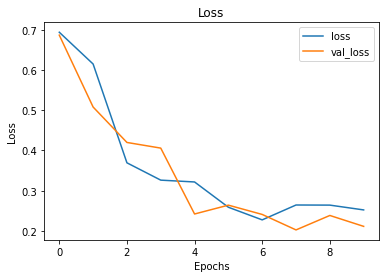

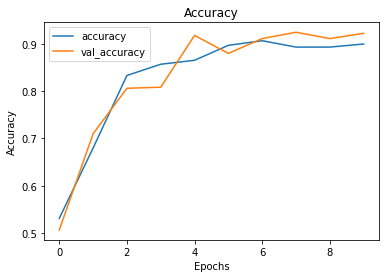

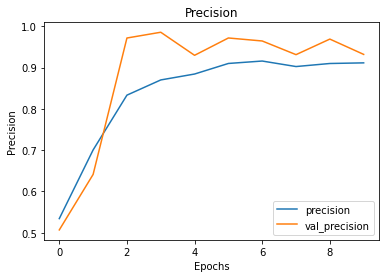

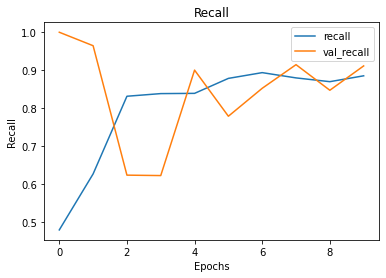

In [76]:
# Visualize Model Metrics
visualize_training_results(pretrain_model_history)

In [77]:
# Evaluate model against Training set
pretrain_results_train = pretrain_model.evaluate(train_generator)
pretrain_results_train

35/35 [==============================] - 32s 906ms/step - loss: 0.2113 - accuracy: 0.9166 - precision: 0.9003 - recall: 0.9369


[0.21126008033752441,
 0.9165915250778198,
 0.9003466367721558,
 0.9368800520896912]

In [78]:
# Evaluate model against Test set
pretrain_results_test = pretrain_model.evaluate(test_generator)
pretrain_results_test

8/8 [==============================] - 4s 470ms/step - loss: 0.1842 - accuracy: 0.9283 - precision: 0.9432 - recall: 0.9114


[0.18423086404800415,
 0.9282700419425964,
 0.943231463432312,
 0.9113923907279968]

## Finetune Pretrain

In [79]:
# Start time of model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [80]:
# Checkpoint, Monitor Loss, Save best results
pretrain_model_checkpoint = tf.keras.callbacks.ModelCheckpoint("Finetune_Pretrain_Checkpoint",
                                                               monitor="loss",
                                                               save_best_only=True)

# Early stop after 10 efforts to learn, each Epoch starts with best saved weights
pretrain_model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                                 monitor="loss",
                                                                 restore_best_weights=True)

In [81]:
# Initialize Pretrain Base Model
finetune_pretrain_base = DenseNet201(weights=None,
                                     include_top=False,
                                     input_shape=(200, 200, 3))

# Define Model Architecture
finetune_pretrain_base = keras.Sequential()
finetune_pretrain_base.add(pretrain_base)
finetune_pretrain_base.add(keras.layers.Flatten())
finetune_pretrain_base.add(keras.layers.Dense(64, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(256, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(1, activation='sigmoid'))

# Do NOT train the base
finetune_pretrain_base.trainable = False

# Summary of Model
finetune_pretrain_base.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 69120)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4423744   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [82]:
# Compile. Binary Crossentropy to Predict Probability to actual class output, Stochastic Gradient Descent via Adam
finetune_pretrain_base.compile(loss="binary_crossentropy",
                               optimizer="adam",
                               metrics=['accuracy',
                                        tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall')])

In [83]:
# Fit Model, 100 Epochs, Checkpoint and Early Stop
finetune_pretrain_model_history = pretrain_model.fit(train_generator,
                                                     validation_data = valid_generator,
                                                     steps_per_epoch = train_generator.n//train_generator.batch_size,
                                                     validation_steps = valid_generator.n//valid_generator.batch_size,
                                                     callbacks=[pretrain_model_checkpoint, pretrain_model_early_stopping],
                                                     epochs=100)

# Stop time of model
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
34/34 [==============================] - 36s 1s/step - loss: 0.2243 - accuracy: 0.9113 - precision: 0.9287 - recall: 0.8918 - val_loss: 0.2275 - val_accuracy: 0.9085 - val_precision: 0.9643 - val_recall: 0.8475
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 2/100
34/34 [==============================] - 37s 1s/step - loss: 0.2173 - accuracy: 0.9146 - precision: 0.9246 - recall: 0.9022 - val_loss: 0.2241 - val_accuracy: 0.9107 - val_precision: 0.9592 - val_recall: 0.8545
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 3/100
34/34 [==============================] - 38s 1s/step - loss: 0.2304 - accuracy: 0.9044 - precision: 0.9112 - recall: 0.8959 - val_loss: 0.1992 - val_accuracy: 0.9263 - val_precision: 0.9401 - val_recall: 0.9107
Epoch 4/100
34/34 [==============================] - 39s 1s/step - loss: 0.2282 - accuracy: 0.9104 - precision: 0.9128 - recall: 0.9086 - val_loss: 0.1965 - val_accuracy: 0.9263 - val_preci

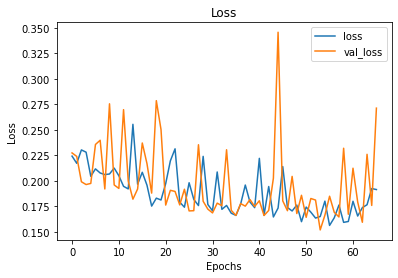

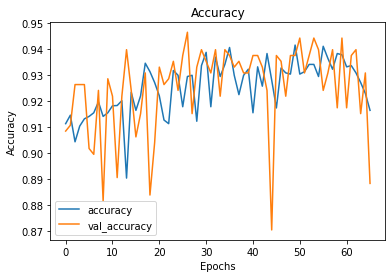

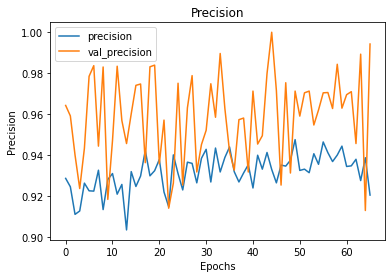

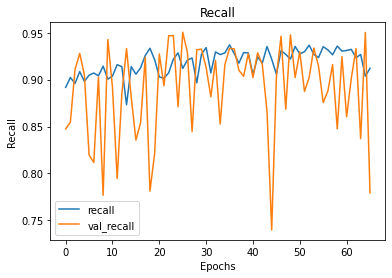

In [86]:
# Visualize Model Metrics
visualize_training_results(finetune_pretrain_model_history)

In [88]:
# Evaluate Model against Training set
finetune_pretrain_results_train = pretrain_model.evaluate(train_generator)
finetune_pretrain_results_train

35/35 [==============================] - 42s 1s/step - loss: 0.1508 - accuracy: 0.9382 - precision: 0.9602 - recall: 0.9143


[0.15082745254039764,
 0.9382326602935791,
 0.9602272510528564,
 0.9143372178077698]

In [89]:
# Evaluate Model against Test set
finetune_pretrain_results_test = pretrain_model.evaluate(test_generator)
finetune_pretrain_results_test

8/8 [==============================] - 5s 634ms/step - loss: 0.1623 - accuracy: 0.9409 - precision: 0.9906 - recall: 0.8903


[0.16234810650348663,
 0.9409282803535461,
 0.9906103014945984,
 0.8902953863143921]

# EVALUATION

In [104]:
# Load saved model
mlp_original_model = keras.models.load_model('MLP_Initial_Model')

In [105]:
scores = mlp_original_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

8/8 [==============================] - 6s 689ms/step - loss: 0.2640 - accuracy: 0.8840 - precision: 0.8730 - recall: 0.8987
Loss of the model: 26.40%
Test Accuracy: 88.40%
Test Precision: 87.30%
Test Recall: 89.87%


In [106]:
# Load saved model
mlp_finetune_model = keras.models.load_model('MLP_Finetune_Checkpoint')

In [107]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = mlp_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

8/8 [==============================] - 6s 695ms/step - loss: 0.2546 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8987
Loss of the model: 25.46%
Test Accuracy: 89.87%
Test Precision: 89.87%
Test Recall: 89.87%


In [108]:
# Load saved model
cnn_initial_model = keras.models.load_model('CNN_Initial_Model')

In [109]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = cnn_initial_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

8/8 [==============================] - 6s 659ms/step - loss: 0.1715 - accuracy: 0.9409 - precision: 0.9336 - recall: 0.9494
Loss of the model: 17.15%
Test Accuracy: 94.09%
Test Precision: 93.36%
Test Recall: 94.94%


In [7]:
# Load saved model
cnn_finetune_model = keras.models.load_model('CNN_Finetune_Checkpoint')

In [111]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = cnn_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

8/8 [==============================] - 5s 637ms/step - loss: 0.1209 - accuracy: 0.9620 - precision: 0.9660 - recall: 0.9578
Loss of the model: 12.09%
Test Accuracy: 96.20%
Test Precision: 96.60%
Test Recall: 95.78%


In [112]:
# Load saved model
pretrain_model = keras.models.load_model('Pretrain_Initial_Model')

In [113]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = pretrain_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

8/8 [==============================] - 7s 562ms/step - loss: 0.1842 - accuracy: 0.9283 - precision: 0.9432 - recall: 0.9114
Loss of the model: 18.42%
Test Accuracy: 92.83%
Test Precision: 94.32%
Test Recall: 91.14%


In [114]:
# Load saved model
pretrain_finetune_model = keras.models.load_model('Finetune_Pretrain_Checkpoint')

In [115]:
# Finalized, Organized, Evaluate against Test set with metrics
scores = pretrain_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f%%"%(scores[0] * 100))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))
print("Test Precision: %.2f%%"%(scores[2] * 100))
print("Test Recall: %.2f%%"%(scores[3] * 100))

8/8 [==============================] - 7s 597ms/step - loss: 0.1623 - accuracy: 0.9409 - precision: 0.9906 - recall: 0.8903
Loss of the model: 16.23%
Test Accuracy: 94.09%
Test Precision: 99.06%
Test Recall: 89.03%


| Metrics           | Loss   | Accuracy | Precision | Recall |
|-------------------|--------|----------|-----------|--------|
| MLP Original      | 26.40% | 88.40%   | 87.30%    | 89.87% |
| MLP Finetune      | 25.46% | 89.87%   | 89.87%    | 89.87%  |
| CNN Original      | 17.15% | 94.09%   | 93.36%    | 94.94% |
| CNN Finetune      | 12.09% | 96.20%   | 96.60%    | 95.78% |
| Pretrain Original | 18.42% | 92.83%   | 94.32%    | 91.14% |
| Pretrain Finetune | 16.23% | 94.09%   | 99.06%    | 89.03% |

In [102]:
# Notebook Stop, Total Time.
notebook_end = datetime.datetime.now()
notebook_elapsed = notebook_end - notebook_original_start
print('Notebook took a total of {}'.format(elapsed))

Notebook took a total of 1:04:49.746035


## Classify Image Prediction

### Pneumonia, True Positive

In [9]:
img_width, img_height = 200, 200
img = image.load_img("./chest_xray/val/PNEUMONIA/person141_bacteria_670.jpeg",target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

cnn_finetune_model.predict(img)

array([[1.]], dtype=float32)

### Normal, True Positive

In [57]:
img_width, img_height = 200, 200
img = image.load_img("./chest_xray/val/NORMAL/NORMAL2-IM-0350-0001.jpeg",target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

cnn_finetune_model.predict(img)

array([[0.]], dtype=float32)

### Normal, False Positive

In [59]:
img_width, img_height = 200, 200
img = image.load_img("./chest_xray/val/NORMAL/NORMAL2-IM-0349-0001.jpeg",target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

cnn_finetune_model.predict(img)

array([[1.]], dtype=float32)